In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
tr = pd.read_csv('../input/X_train.csv')
te = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
ss = pd.read_csv('../input/sample_submission.csv')


tr.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


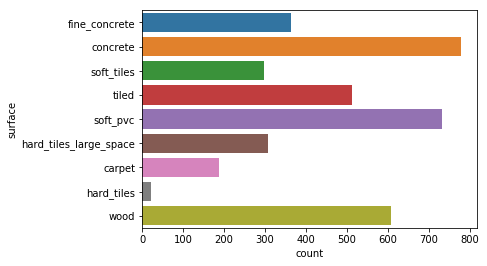

In [3]:
countplot(y = 'surface', data = target)
plt.show()

Feature Engineering


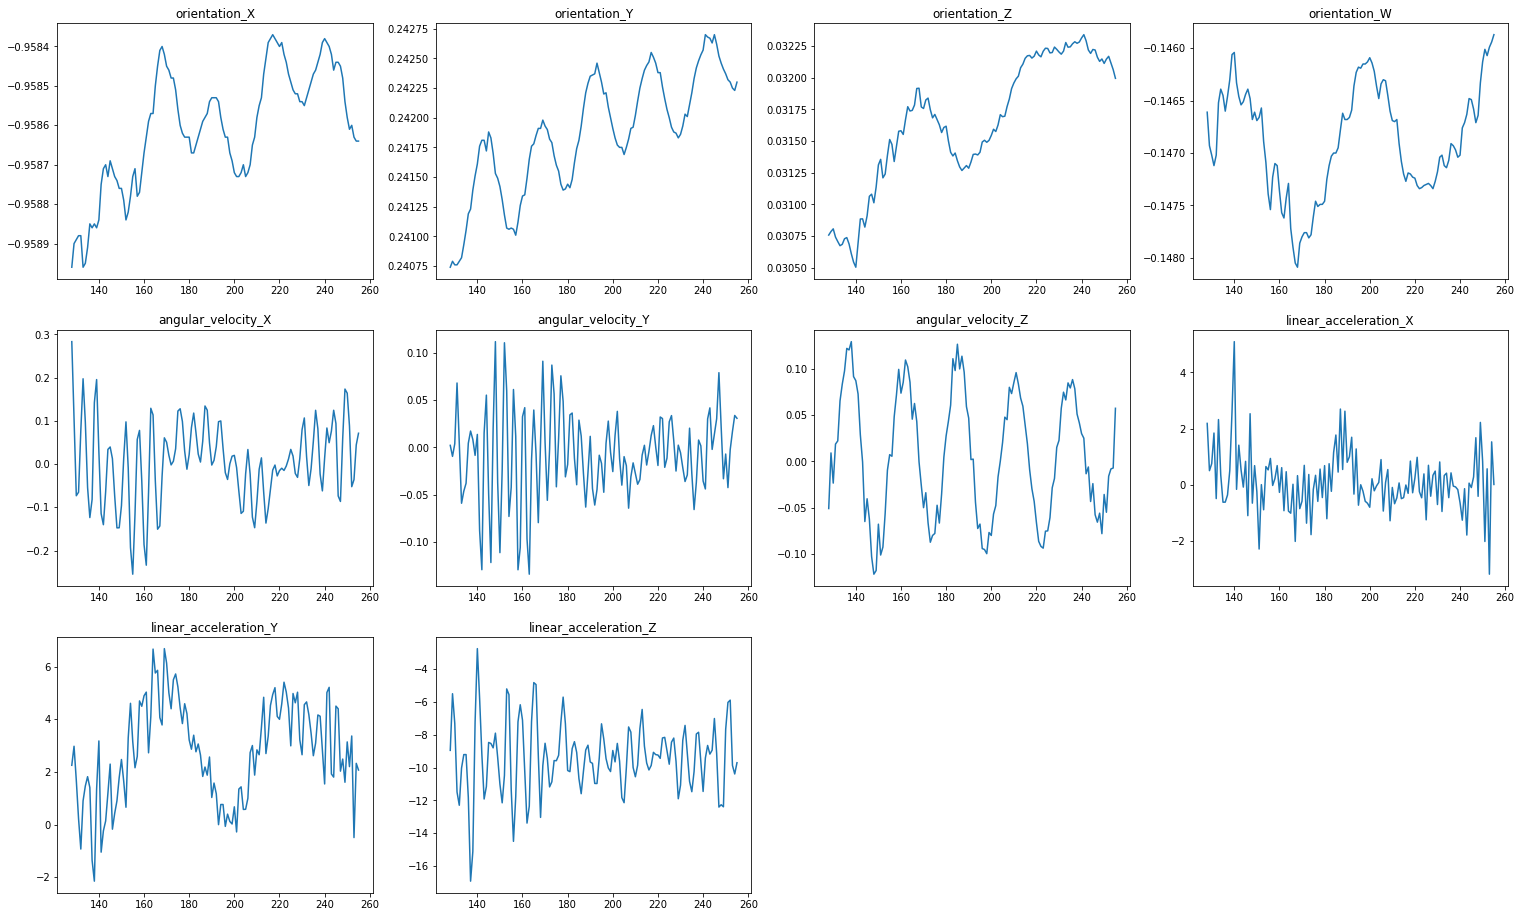

In [4]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(tr.columns[3:]):
    plt.subplot(3,4, i + 1)
    plt.plot(tr.loc[tr['series_id'] == 1, col])
    plt.title(col)

Reference from  https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots

In [5]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z




def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5   
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 0.5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_Moving_average_10_mean'] = actual.groupby(['series_id'])[col].rolling(window=10).mean().mean(skipna=True)
        new[col + '_Moving_average_16_mean'] = actual.groupby(['series_id'])[col].rolling(window=16).mean().mean(skipna=True)
        new[col + '_Moving_average_10_std'] = actual.groupby(['series_id'])[col].rolling(window=10).std().mean(skipna=True)
        new[col + '_Moving_average_16_std'] = actual.groupby(['series_id'])[col].rolling(window=16).std().mean(skipna=True)
        
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [6]:
tr = fe(tr)
te = fe(te)
tr.head()


,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_Moving_average_10_mean,orientation_X_Moving_average_16_mean,orientation_X_Moving_average_10_std,orientation_X_Moving_average_16_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_Moving_average_10_mean,orientation_Y_Moving_average_16_mean,orientation_Y_Moving_average_10_std,orientation_Y_Moving_average_16_std,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_Moving_average_10_mean,orientation_Z_Moving_average_16_mean,orientation_Z_Moving_average_10_std,orientation_Z_Moving_average_16_std,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_W_mean,...,euler_z_abs_min,total_angle_mean,total_angle_min,total_angle_max,total_angle_std,total_angle_Moving_average_10_mean,total_angle_Moving_average_16_mean,total_angle_Moving_average_10_std,total_angle_Moving_average_16_std,total_angle_max_to_min,total_angle_mean_abs_change,total_angle_mean_change_of_abs_change,total_angle_abs_max,total_angle_abs_min,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_Moving_average_10_mean,angle_vs_acc_Moving_average_16_mean,angle_vs_acc_Moving_average_10_std,angle_vs_acc_Moving_average_16_std,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_Moving_average_10_mean,angle_vs_vel_Moving_average_16_mean,angle_vs_vel_Moving_average_10_std,angle_vs_vel_Moving_average_16_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,-0.01805,-0.01805,0.000367,0.00057,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,-0.63456,-0.63306,0.000471,0.075062,0.075062,0.000349,0.000541,0.997636,0.000018,0.000000e+00,0.63456,0.63306,-0.105474,-0.106140,-0.104610,0.000432,0.012458,0.012458,0.000169,0.000233,0.985585,0.000051,7.936508e-08,0.106140,0.104610,-0.106470,...,1.393233,3.166227,3.164289,3.168565,0.001183,3.353369,3.353368,0.000694,0.001019,1.001351,0.000105,5.882228e-07,3.168565,3.164289,0.321935,0.251897,0.445076,0.034786,0.341818,0.341817,0.056143,0.058577,1.766897,0.023178,0.000123,0.445076,0.251897,71.253309,19.504720,298.761364,44.060971,50.16809,50.142653,22.746342,25.018933,15.317388,37.481365,0.280575,298.761364,19.504720
1,-0.958606,-0.95896,-0.95837,0.000151,-0.01805,-0.01805,0.000367,0.00057,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,0.24074,0.24270,0.000499,0.075062,0.075062,0.000349,0.000541,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.031650,0.030504,0.032341,0.000508,0.012458,0.012458,0.000169,0.000233,1.060222,0.000048,3.253968e-07,0.032341,0.030504,-0.146876,...,0.490164,2.882573,2.880123,2.884601,0.001106,3.353369,3.353368,0.000694,0.001019,1.001555,0.000211,-3.301104e-06,2.884601,2.880123,0.295598,0.169758,0.491481,0.056245,0.341818,0.341817,0.056143,0.058577,2.895188,0.041363,-0.001057,0.491481,0.169758,33.584444,10.012514,142.881670,21.735220,50.16809,50.142653,22.746342,25.018933,14.270310,14.932243,0.040438,142.881670,10.012514
2,-0.512057,-0.51434,-0.50944,0.001377,-0.01805,-0.01805,0.000367,0.00057,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,-0.84779,-0.84490,0.000785,0.075062,0.075062,0.000349,0.000541,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,-0.129371,-0.130300,-0

In [7]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True)
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])
target.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


Building a model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=20, shuffle=True, random_state=20)
pred_e = np.zeros((te.shape[0], 9))
pred_r = np.zeros((tr.shape[0]))
score = 0

In [10]:
for i, (train_index, test_index) in enumerate(folds.split(tr, target['surface'])):
    
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1)
    clf.fit(tr.iloc[train_index], target['surface'][train_index])
 
    pred_r[test_index] = clf.predict(tr.iloc[test_index])
    pred_e += clf.predict_proba(te) / folds.n_splits
    
    score += clf.score(tr.iloc[test_index], target['surface'][test_index])
    print('score ', clf.score(tr.iloc[test_index], target['surface'][test_index]))
   

score  0.9025641025641026
score  0.9536082474226805
score  0.8917525773195877
score  0.8704663212435233
score  0.9326424870466321
score  0.8911917098445595
score  0.9430051813471503
score  0.8958333333333334
score  0.8900523560209425
score  0.9210526315789473
score  0.9157894736842105
score  0.9315789473684211
score  0.8941798941798942
score  0.8941798941798942
score  0.9148936170212766
score  0.9148936170212766
score  0.9308510638297872
score  0.93048128342246
score  0.893048128342246
score  0.9354838709677419


In [11]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

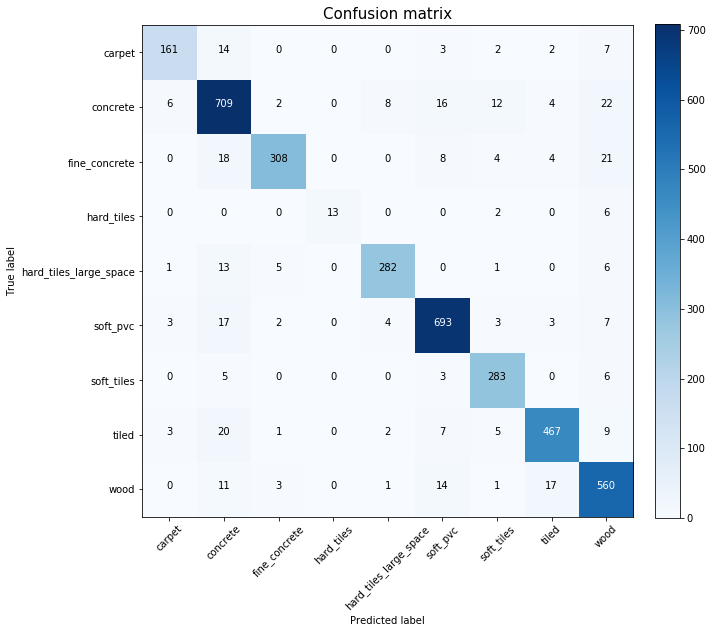

In [12]:
plot_confusion_matrix(target['surface'], pred_r, le.classes_)

In [13]:
ss['surface'] = le.inverse_transform(pred_e.argmax(axis=1))
ss.to_csv('rf.csv', index=False)
ss.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood
